# asd_a4_processing

@author: David Clemens-Sewall

Notebook for applying automated processing to ASD level a1 files to flag data.

First, 
  1. Parabolic correction from 750 to 1000 nm for temperature-offset between VNIR and SWIR (procedure from ASD manual).

Next, the following automated checks for which the entire scan is flagged:

  2. Visible wavelengths include albedos greater than 1 (Flag 2)
  3. Slope of albedos between 400 and 450 nm is less than 1.6e-4 (Flag 3)
  4. Time between incident and reflected measurement is less than seven seconds (Flag 4)
  5. Slope condition and transition time condition are both met (Flag 5)
  
Then, the following automated checks flag portions of the scan that meet certain conditions.

  6. Variability in the incident by wavelength. Greater than 15% change averaged between the preceeding and following measurement (Flag 6)
  7. Insufficient incident irradiance; below 1250 counts for the SWIR1 detector (1001 - 1800 nm) and below 5500 counts for the SWIR2 detector (1801 - 2500 nm). (Flag 7)

Finally, albedos where the reflected measurement is negative are set to zero.


In [1]:
# Imports
import os
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Data paths
a1_dir = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'a1')
a4_dir = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'a4')
a5_dir = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'a5')

filepaths = glob.glob(os.path.join(a1_dir, '*.a1.h5'))

In [134]:
def parabolic_correction(df_a4):
    """
    Apply parabolic correction to rescale albedos between 750 and 1000 nm to smooth
    offset from 1000 to 1001 nm
    
    Parameters:
    -----------
    df_a4: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
        
    Returns:
    --------
    None. But df_a4 is modified in-place.
    """
    
    # Get albedo offset from 1000 to 1001 nm
    wvs = [1000, 1001]
    df_para = df_a4.query('variable == "albedo" & wavelength in @wvs').reset_index()
    df_para = df_para.pivot(columns='wavelength', values='value',
                            index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'variable'])
    df_para['factor'] = (df_para[1001] - df_para[1000])/df_para[1000]
    df_para.drop(columns=wvs, inplace=True)

    # Create dataframe of multiplicative scales
    wvs = np.arange(251).T + 750
    arr_scales = ((wvs - 750)**2)/(251**2) # parabolic transformed wavelength coordinate
    arr_scales = np.outer(df_para['factor'].values, arr_scales) + 1
    df_scales = pd.DataFrame(data=arr_scales, index=df_para.index, columns=wvs)
    df_scales = df_scales.melt(var_name='wavelength', ignore_index=False)
    df_scales.set_index('wavelength', append=True, inplace=True)
    df_scales = df_scales.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable']) 

    # Update values in df_a4
    df_a4.update((df_scales*df_a4).query('variable == "albedo"'))

In [135]:
def vis_alb_filter(df_a4, wv_max=750, thrsh=1.0):
    """
    Flag entire scans when any visible albedo exceeds thrsh
    
    Parameters:
    -----------
    df_a4: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    wv_max: int, optional
        Maximum wavelength considered part of the visible. The default is 750 (nm).
    thrhs: float, optional
        Albedo threshold at and above which to flag scan. The default is 1.0.
        
    Returns:
    --------
    None. But df_a4 is modified in-place.
    """
    
    # Get positions to filter
    df_temp = df_a4.query('wavelength <= @wv_max & variable == "albedo"')
    pos_filt = np.unique(df_temp[df_temp['value']>=1.0].index.get_level_values('position').values)
    
    # Update flags
    df_a4.loc[df_a4.eval('variable == "asd_quality_flag" & position in @pos_filt'), 'value'] = 2.0

In [136]:
def slope_filter(df_a4, slope_threshold=-1.6e-4, wv_min=400, wv_max=450):
    """
    Flags scans in-place slope between wv_min and wv_max is less than slope_threshold
    
    Parameters:
    -----------
    df_a4: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    slope_threshold: float, optional
        below this slope, flag entire scan. The default is -1.6e-4
    wv_min: int, optional
        Lower end of wavelength range. The default is 400 (nm).
    wv_max: int, optional
        Upper end of wavelength range. The default is 450 (nm).
        
    Returns:
    --------
    None. But df_a4 is modified in-place.
    """
    
    # Extract albedos
    df_alb = df_a4.query('variable == "albedo" & wavelength >= @wv_min & wavelength <= @wv_max'
                        ).reset_index().drop(
        columns=['timestamp_akdt', 'site', 'location', 'repetition', 'variable'])
    df_alb = df_alb.pivot(columns='position', index='wavelength', values='value')

    # Compute slopes of linear regressions
    arr_pos = df_alb.columns.values
    arr_slopes = np.zeros(arr_pos.shape)
    for i in np.arange(arr_pos.size):
        arr_slopes[i] = np.polynomial.Polynomial.fit(
            df_alb.index.values, df_alb[arr_pos[i]].values, 1).coef[1]

    # Get positions to filter
    pos_filt = arr_pos[arr_slopes < slope_threshold]
    
    # Update flags
    df_a4.loc[df_a4.eval('variable == "asd_quality_flag" & position in @pos_filt'), 'value'] = 3.0

In [137]:
def time_diff_filter(df_a4, min_flip_s=7):
    """
    Flags scans in-place if time between incident and reflected measurement is less than min_flip_s
    
    Parameters:
    -----------
    df_a4: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    min_flip_s: float, optional
        below this flip time, flag entire scan. The default is 7 (seconds)
        
    Returns:
    --------
    None. But df_a4 is modified in-place.
    """
    
    # Get positions to filter
    pos_filt = df_a4.query('variable == "asd_time_diff_s" & value >= -@min_flip_s').index.get_level_values('position')
    
    # Update flags
    df_a4.loc[df_a4.eval('variable == "asd_quality_flag" & position in @pos_filt' +
                    ' & value != 3.0'), 'value'] = 4.0
    df_a4.loc[df_a4.eval('variable == "asd_quality_flag" & position in @pos_filt' +
                    ' & value == 3.0'), 'value'] = 5.0

In [138]:
def inc_var_filter(df_a4, chg_thrsh=0.15):
    """
    Flags wavelengths where the incident changes by more than chg_thrsh
    
    Parameters:
    -----------
    df_a4: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    chg_thrsh: float, optional
        Above this ratio of change in incident (averaged between scan before and after), flag wavelength. The default is 0.15
        
    Returns:
    --------
    None. But df_a4 is modified in-place.
    """
    
    # Get dataframe of incident values
    df_inc = df_a4.query('variable == "incident_solar_counts"').reset_index()
    df_inc = df_inc.pivot(columns='wavelength', values='value',
                    index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'variable'])
    df_inc.sort_index(level='timestamp_akdt', inplace=True)

    # Compute the mean of the change before and after each measurement, accounting for the first and last measurements
    df_chg = (df_inc.diff(periods=1).abs()/df_inc).add(df_inc.diff(periods=-1).abs()/df_inc, fill_value=0.0)/2
    df_chg.iloc[[0, -1]] *= 2

    # Get positions and wavelengths exceeding threshold
    df_mask = (df_chg > chg_thrsh).melt(ignore_index=False)

    # Update flags (ugly... indices don't match because incident and reflected have diff timestamps)
    df_mask.reset_index(['timestamp_akdt', 'variable'], inplace=True)
    df_mask['variable'] = 'asd_quality_flag'
    df_mask.drop(columns='timestamp_akdt', inplace=True)
    df_mask.set_index(['wavelength', 'variable'], append=True, inplace=True)
    df_mask = df_mask.reorder_levels(
        ['site', 'location', 'position', 'repetition', 'wavelength', 'variable'])
    df_a4.reset_index('timestamp_akdt', inplace=True)
    df_a4.loc[df_mask.index[df_mask['value']], 'value'] = 6.0
    df_a4.set_index('timestamp_akdt', inplace=True, append=True)
    df_a4 = df_a4.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])
    

In [216]:
def inc_mag_filter(df_a4, swir1_thrsh=1250, swir2_thrsh=5500):
    """
    Flags wavelengths where the incident is below thresholds
    
    Parameters:
    -----------
    df_a4: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    swir1_thrsh: float, optional
        Below this incident value flag swir1 wavelengths. The default is 1250 (counts)
    swir2_thrsh: float, optional
        Below this incident value flag swir2 wavelengths. The default is 5500 (counts)
        
    Returns:
    --------
    None. But df_a4 is modified in-place.
    """
    
    df_a4.reset_index('timestamp_akdt', inplace=True)
    
    # swir1
    wv_min = 1001
    wv_max = 1800
    s_mask = df_a4.query('variable == "incident_solar_counts" ' +
                          '& wavelength >= @wv_min & wavelength <= @wv_max')['value'] <= swir1_thrsh
    df_mask = s_mask.reset_index('variable')
    df_mask['variable'] = 'asd_quality_flag'
    df_mask.set_index('variable', append=True, inplace=True)
    df_a4.loc[df_mask.index[df_mask['value']], 'value'] = 7.0

    # swir2
    wv_min = 1801
    s_mask = df_a4.query('variable == "incident_solar_counts" ' +
                          '& wavelength >= @wv_min')['value'] <= swir2_thrsh
    df_mask = s_mask.reset_index('variable')
    df_mask['variable'] = 'asd_quality_flag'
    df_mask.set_index('variable', append=True, inplace=True)
    df_a4.loc[df_mask.index[df_mask['value']], 'value'] = 7.0

    df_a4.set_index('timestamp_akdt', inplace=True, append=True)
    df_a4 = df_a4.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])
    

In [249]:
def negative_reflected(df_a4):
    """
    Sets albedo to zero where reflected value is negative
    
    Parameters:
    -----------
    df_a4: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
        
    Returns:
    --------
    df_a4
    """
    
    df_a4 = df_a4.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])

    # Get negative reflected values
    df_neg = df_a4.query('variable == "reflected_solar_counts" & value < 0.0').copy()

    # Update albedo values
    df_neg.reset_index('variable', inplace=True)
    df_neg['variable'] = 'albedo'
    df_neg.set_index('variable', append=True, inplace=True)
    df_neg = df_neg.reorder_levels(
            ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])
    df_a4.loc[df_neg.index, 'value'] = 0.0
    
    return df_a4

In [279]:
def handler_convert_to_a4_a5(a1_path, a4_dir, a5_dir):
    # Read in a1 data
    df_a4 = pd.read_hdf(a1_path, mode='r')
    
    # Correct VNIR/SWIR1 offset
    parabolic_correction(df_a4)
    # Apply whole scan filters
    vis_alb_filter(df_a4)
    slope_filter(df_a4)
    time_diff_filter(df_a4)
    # Apply wavelength filters
    inc_var_filter(df_a4)
    inc_mag_filter(df_a4)
    # Set albedos to zero where reflected is negative
    df_a4 = negative_reflected(df_a4)
    
    # Replace all flag 0.0 (unprocessed data) with flag 1.0 (data that has passed automated qc)
    df_a4.loc[df_a4.eval('variable == "asd_quality_flag" & value == 0.0'), 'value'] = 1.0
    
    # Write df_a4 to disk
    a4_name = os.path.basename(a1_path).replace('a1', 'a4')
    df_a4.to_hdf(os.path.join(a4_dir, a4_name), key='data', mode='w', format='table',
                 complevel=9, complib='blosc:lz4')
    print("wrote: " + a4_name)
    
    # Create a5 and write to disk
    df_a5 = df_a4.query('variable in ["albedo", "asd_quality_flag"] ').reset_index()
    df_a5 = df_a5.pivot(columns='variable', values='value',
        index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'wavelength'])
    df_a5 = df_a5[df_a5['asd_quality_flag'] == 1.0]['albedo'].reset_index()
    df_a5 = df_a5.pivot(columns=['timestamp_akdt', 'site', 'location', 'repetition', 'position'],
                       index='wavelength', values='albedo')
    df_a5 = df_a5.round(3)
    a5_name = os.path.basename(a1_path).replace('a1', 'a5').replace('h5', 'csv')
    df_a5.to_csv(os.path.join(a5_dir, a5_name))
    print("wrote: " + a5_name)


In [281]:
# convert data
for i in range(len(filepaths)):
    print(i)
    handler_convert_to_a4_a5(filepaths[i], a4_dir, a5_dir)
    print('')

0
wrote: salvo_arm_line_asd-albedo_20240419.a4.h5
wrote: salvo_arm_line_asd-albedo_20240419.a5.csv

1
wrote: salvo_arm_line_asd-albedo_20240524.a4.h5
wrote: salvo_arm_line_asd-albedo_20240524.a5.csv

2
wrote: salvo_arm_line_asd-albedo_20240525.a4.h5
wrote: salvo_arm_line_asd-albedo_20240525.a5.csv

3
wrote: salvo_arm_line_asd-albedo_20240527.a4.h5
wrote: salvo_arm_line_asd-albedo_20240527.a5.csv

4
wrote: salvo_arm_line_asd-albedo_20240529.a4.h5
wrote: salvo_arm_line_asd-albedo_20240529.a5.csv

5
wrote: salvo_arm_line_asd-albedo_20240603.a4.h5
wrote: salvo_arm_line_asd-albedo_20240603.a5.csv

6
wrote: salvo_arm_line_asd-albedo_20240605.a4.h5
wrote: salvo_arm_line_asd-albedo_20240605.a5.csv

7
wrote: salvo_arm_line_asd-albedo_20240606.a4.h5
wrote: salvo_arm_line_asd-albedo_20240606.a5.csv

8
wrote: salvo_arm_line_asd-albedo_20240610.a4.h5
wrote: salvo_arm_line_asd-albedo_20240610.a5.csv

9
wrote: salvo_arm_line_asd-albedo_20240612.a4.h5
wrote: salvo_arm_line_asd-albedo_20240612.a5.csv



## Below here is scratchwork

In [7]:
filepaths

['..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240419.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240524.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240525.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240527.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240529.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240603.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240605.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240606.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_arm_line_asd-albedo_20240610.a1.h5',
 '..\\..\\export\\final-upload-data\\spectral_

In [267]:
#a1_path = filepaths[2]
a1_path = filepaths[21]
df_a4 = pd.read_hdf(a1_path, mode='r')

In [268]:
a1_path

'..\\..\\export\\final-upload-data\\spectral_albedo_2024\\a1\\salvo_ice_line_asd-albedo_20240417.a1.h5'

In [269]:
parabolic_correction(df_a4)

In [270]:
vis_alb_filter(df_a4)

In [271]:
slope_filter(df_a4)

In [272]:
time_diff_filter(df_a4)

In [273]:
inc_var_filter(df_a4)

In [274]:
inc_mag_filter(df_a4)

In [275]:
df_a4 = negative_reflected(df_a4)

In [245]:
df_a4 = df_a4.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])

# Get negative reflected values
df_neg = df_a4.query('variable == "reflected_solar_counts" & value < 0.0').copy()

# Update albedo values
df_neg.reset_index('variable', inplace=True)
df_neg['variable'] = 'albedo'
df_neg.set_index('variable', append=True, inplace=True)
df_neg = df_neg.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])
df_a4.loc[df_neg.index, 'value'] = 0.0

In [228]:
df_neg

value
timestamp_akdt            site location position repetition wavelength variable           
2024-04-19 14:11:20-08:00 arm  line     0        1.0        1362.0     albedo    -1.265923
                                                            1363.0     albedo    -3.451901
2024-04-19 14:25:47-08:00 arm  line     60       1.0        1366.0     albedo    -1.695978
2024-04-19 14:37:10-08:00 arm  line     110      1.0        1366.0     albedo    -1.791819
2024-04-19 14:25:47-08:00 arm  line     60       1.0        1367.0     albedo    -2.493075
...                                                                                    ...
2024-04-19 14:46:23-08:00 arm  line     155      1.0        2500.0     albedo   -46.353708
2024-04-19 14:48:57-08:00 arm  line     165      1.0        2500.0     albedo   -43.023704
2024-04-19 14:51:53-08:00 arm  line     180      1.0        2500.0     albedo   -39.878044
2024-04-19 14:52:59-08:00 arm  line     185      1.0        2500.0     albedo   -54.113510
2024-04-19 14:54:58-08:00 arm  line     195      1.0        2500.0     albedo   -18.034920

[3174 rows x 1 columns]

In [260]:
df_a4

,,,,,,,value
timestamp_akdt,site,location,position,repetition,wavelength,variable,
2024-04-19 14:10:54-08:00,arm,line,0,1.0,350.0,incident_solar_counts,4039.254489
2024-04-19 14:11:20-08:00,arm,line,0,1.0,350.0,reflected_solar_counts,3706.906630
2024-04-19 14:12:20-08:00,arm,line,5,1.0,350.0,incident_solar_counts,4074.302244
2024-04-19 14:12:50-08:00,arm,line,5,1.0,350.0,reflected_solar_counts,3825.859000
2024-04-19 14:13:35-08:00,arm,line,10,1.0,350.0,incident_solar_counts,4086.215718
...,...,...,...,...,...,...,...
2024-04-19 14:51:53-08:00,arm,line,180,1.0,NaN,asd_time_diff_s,-25.000000
2024-04-19 14:52:59-08:00,arm,line,185,1.0,NaN,asd_time_diff_s,-26.000000
2024-04-19 14:54:00-08:00,arm,line,190,1.0,NaN,asd_time_diff_s,-27.000000


In [276]:
print(df_a4.query('variable == "albedo"').min())

value    0.0
dtype: float64


In [262]:
df_a4.query('position == 195 & wavelength == 1900.0')

value
timestamp_akdt            site location position repetition wavelength variable                         
2024-04-19 14:54:33-08:00 arm  line     195      1.0        1900.0     incident_solar_counts    0.009170
2024-04-19 14:54:58-08:00 arm  line     195      1.0        1900.0     reflected_solar_counts -20.017217
                                                                       albedo                   0.000000
                                                                       asd_quality_flag         7.000000

In [ ]:
df_a4.query('position == 50 & wavelength == 1900.0')

In [ ]:

# Incident below threshold

In [204]:
swir1_thrsh = 1250
swir2_thrsh = 5500

df_a4.reset_index('timestamp_akdt', inplace=True)

# swir1
wv_min = 1001
wv_max = 1800
s_mask = df_a4.query('variable == "incident_solar_counts" ' +
                      '& wavelength >= @wv_min & wavelength <= @wv_max')['value'] <= swir1_thrsh
df_mask = s_mask.reset_index('variable')
df_mask['variable'] = 'asd_quality_flag'
df_mask.set_index('variable', append=True, inplace=True)
df_a4.loc[df_mask.index[df_mask['value']], 'value'] = 7.0

# swir2
wv_min = 1801
s_mask = df_a4.query('variable == "incident_solar_counts" ' +
                      '& wavelength >= @wv_min')['value'] <= swir2_thrsh
df_mask = s_mask.reset_index('variable')
df_mask['variable'] = 'asd_quality_flag'
df_mask.set_index('variable', append=True, inplace=True)
df_a4.loc[df_mask.index[df_mask['value']], 'value'] = 7.0

df_a4.set_index('timestamp_akdt', inplace=True, append=True)
df_a4 = df_a4.reorder_levels(
    ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])

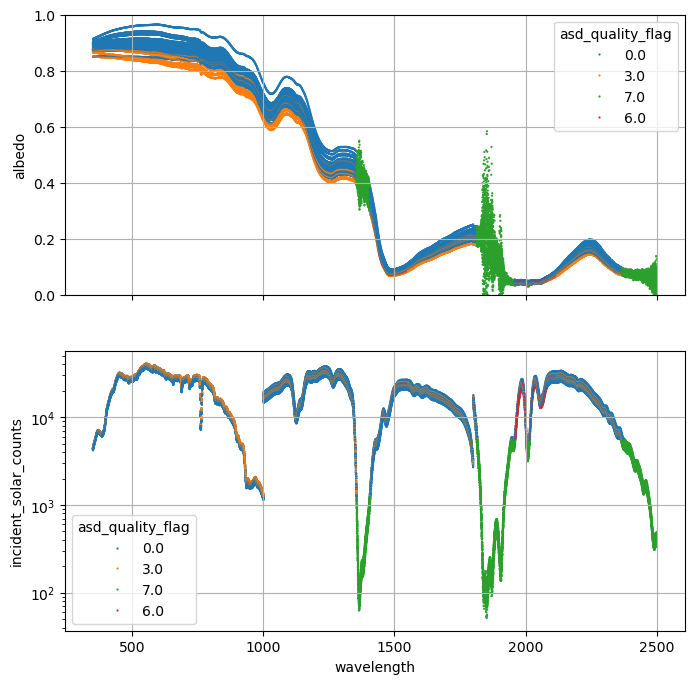

In [277]:
pos = [0, 50, 140, 145, 150]
pos = np.arange(41)*5

df_temp = df_a4.query('variable in ["albedo", "incident_solar_counts", "asd_quality_flag"]').reset_index(
    ).drop(columns=['timestamp_akdt', 'site', 'location', 'repetition']).pivot(
    index=['wavelength', 'position'], columns='variable', values='value')
df_temp['asd_quality_flag'] = df_temp['asd_quality_flag'].astype("string")


f, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))

sns.scatterplot(data=df_temp.query('position in @pos'), x='wavelength', y='albedo', hue='asd_quality_flag',
           marker='.', edgecolor='none', s=10, ax=axs[0])
axs[0].set_ylim([0, 1])
axs[0].grid()

sns.scatterplot(data=df_temp.query('position in @pos'), x='wavelength', y='incident_solar_counts', hue='asd_quality_flag',
           marker='.', edgecolor='none', s=10, ax=axs[1])
axs[1].set_yscale('log')
axs[1].grid()

In [278]:
df_a4.query('variable == "asd_time_diff_s"')

value
timestamp_akdt site location position repetition wavelength variable              
NaT            ice  line     0        1.0        NaN        asd_time_diff_s    NaN
                             5        1.0        NaN        asd_time_diff_s    NaN
                             10       1.0        NaN        asd_time_diff_s    NaN
                             15       1.0        NaN        asd_time_diff_s    NaN
                             20       1.0        NaN        asd_time_diff_s    NaN
                             25       1.0        NaN        asd_time_diff_s    NaN
                             30       1.0        NaN        asd_time_diff_s    NaN
                             35       1.0        NaN        asd_time_diff_s    NaN
                             40       1.0        NaN        asd_time_diff_s    NaN
                             45       1.0        NaN        asd_time_diff_s    NaN
                             50       1.0        NaN        asd_time_diff_s    NaN
                             55       1.0        NaN        asd_time_diff_s    NaN
                             60       1.0        NaN        asd_time_diff_s    NaN
                             65       1.0        NaN        asd_time_diff_s    NaN
                             70       1.0        NaN        asd_time_diff_s    NaN
                             75       1.0        NaN        asd_time_diff_s    NaN
                             80       1.0        NaN        asd_time_diff_s    NaN
                             85       1.0        NaN        asd_time_diff_s    NaN
                             90       1.0        NaN        asd_time_diff_s    NaN
                             95       1.0        NaN        asd_time_diff_s    NaN
                             100      1.0        NaN        asd_time_diff_s    NaN
                             105      1.0        NaN        asd_time_diff_s    NaN
                             110      1.0        NaN        asd_time_diff_s    NaN
                             115      1.0        NaN        asd_time_diff_s    NaN
                             120      1.0        NaN        asd_time_diff_s    NaN
                             125      1.0        NaN        asd_time_diff_s    NaN
                             130      1.0        NaN        asd_time_diff_s    NaN
                             135      1.0        NaN        asd_time_diff_s    NaN
                             140      1.0        NaN        asd_time_diff_s    NaN
                             145      1.0        NaN        asd_time_diff_s    NaN
                             150      1.0        NaN        asd_time_diff_s    NaN